                 Generalized Linear Model Regression Results                  
Dep. Variable:             Claim_Cost   No. Observations:                 1234
Model:                            GLM   Df Residuals:                     1194
Model Family:                   Gamma   Df Model:                           39
Link Function:                    Log   Scale:                         0.27678
Method:                          IRLS   Log-Likelihood:                -6127.2
Date:                Sat, 03 May 2025   Deviance:                       342.33
Time:                        19:04:38   Pearson chi2:                     330.
No. Iterations:                    13   Pseudo R-squ. (CS):             0.3062
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

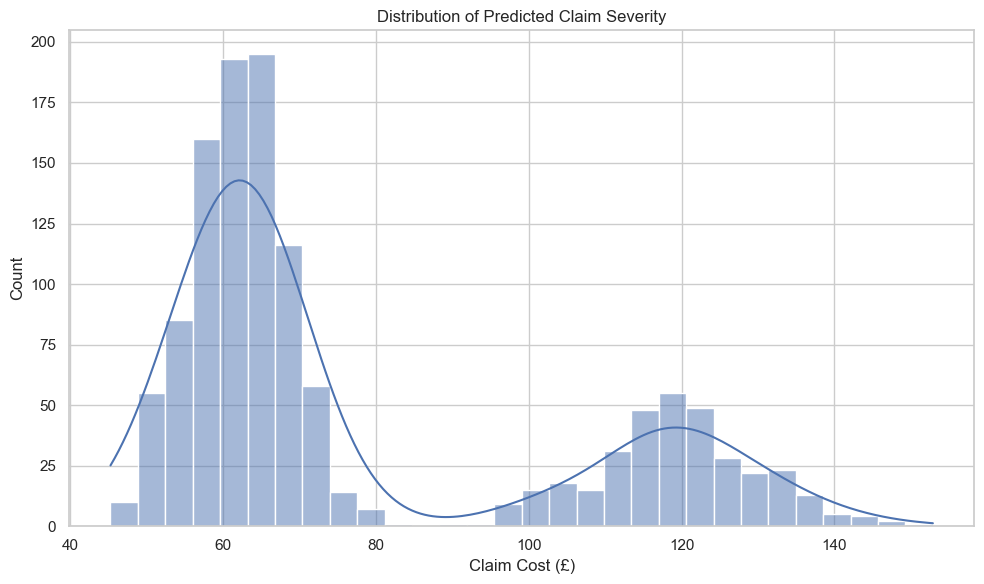

In [3]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Step 2: Load Frequency Output File (only keep claims)
df = pd.read_csv('../data/processed/device_insurance_with_freq_predictions.csv')
df_severity = df[df['Claim_Made'] == 1].copy()

# Step 3: Drop unnecessary columns
model_df = df_severity.drop(columns=['Policy_ID', 'Claim_Made', 'Predicted_Claim_Frequency', 'Plan_Price'])

# Step 4: Encode categoricals
categorical_vars = ['Device_Type', 'Brand', 'Vendor', 'Region', 'Sales_Channel', 'Age_Band']
model_df = pd.get_dummies(model_df, columns=categorical_vars, drop_first=True)

# Step 5: Set up X and y
X = model_df.drop(columns=['Claim_Cost', 'Customer_Age', 'Retail_Price', 'Plan_Duration'])
y = model_df['Claim_Cost']

# Ensure numeric types
X = X.astype(float)
X = sm.add_constant(X)

# Step 6: Fit Gamma GLM with log link
gamma_model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.Log()))
gamma_results = gamma_model.fit()

# Step 7: Print Summary
print(gamma_results.summary())

# Step 8: Predict Severity
df_severity['Predicted_Claim_Severity'] = gamma_results.predict(X)

# Step 9: Merge predictions back to full dataset
df_full = df.copy()
df_full = df_full.merge(
    df_severity[['Policy_ID', 'Predicted_Claim_Severity']],
    on='Policy_ID',
    how='left'
)

# Fill NA severity for non-claim rows with average prediction
avg_sev = df_severity['Predicted_Claim_Severity'].mean()
df_full['Predicted_Claim_Severity'] = df_full['Predicted_Claim_Severity'].fillna(avg_sev)

# Step 10: Save Enriched File
df_full.to_csv('../data/processed/device_insurance_with_severity_predictions.csv', index=False)
print("\n Severity predictions saved to: ../data/processed/device_insurance_with_severity_predictions.csv")

# Step 11: Plot Predicted Severity Distribution
sns.histplot(df_severity['Predicted_Claim_Severity'], bins=30, kde=True)
plt.title("Distribution of Predicted Claim Severity")
plt.xlabel("Claim Cost (£)")
plt.tight_layout()
plt.show()

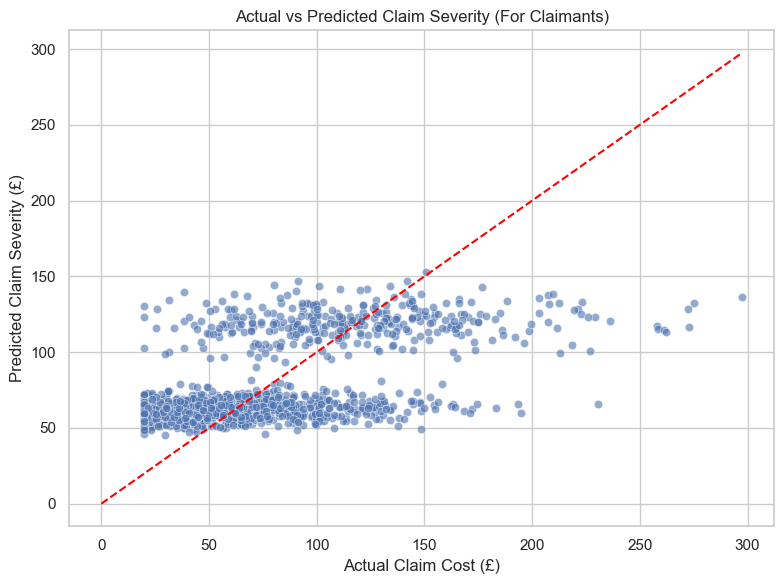

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only records where a claim was made
df_claims = df_full[df_full['Claim_Made'] == 1].copy()

# Scatter plot: actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Claim_Cost',
    y='Predicted_Claim_Severity',
    data=df_claims,
    alpha=0.6
)
plt.plot([0, df_claims['Claim_Cost'].max()], [0, df_claims['Claim_Cost'].max()], color='red', linestyle='--')
plt.xlabel('Actual Claim Cost (£)')
plt.ylabel('Predicted Claim Severity (£)')
plt.title('Actual vs Predicted Claim Severity (For Claimants)')
plt.savefig('../reports/figures/actual_vs_predicted_severity.png', bbox_inches='tight')
plt.tight_layout()
plt.show()